# Stage 1: Data Collection

In [45]:
# Installing the Meteostat library, which provides access to historical weather data 
# such as temperature, wind speed, precipitation, and more — used for analyzing flight delays.

# Install Meteostat
!pip install meteostat

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [46]:
# Importing required libraries:
# datetime → to define the time period for weather data collection (2020–2024)
# meteostat → to fetch weather observations for selected airports
# pandas → to store and manage the downloaded data efficiently
from datetime import datetime
from meteostat import Point, Hourly
import pandas as pd

In [47]:
# Defining the time range for which weather data will be collected (January 2020 – December 2024)
start = datetime(2020, 1, 1)
end   = datetime(2024, 12, 31)

In [48]:
# Defining the latitude and longitude coordinates for both Houston airports:
iah = Point(29.9902, -95.3368, 30)   # George Bush Intercontinental
hou = Point(29.6454, -95.2789, 14)   # William P. Hobby

In [49]:
# Fetching hourly weather data for IAH from the Meteostat database for 2020–2024
print("Fetching IAH data...")
data_iah = Hourly(iah, start, end).fetch()

Fetching IAH data...


In [50]:
# Fetching hourly weather data for HOU from the Meteostat database for 2020–2024
print("Fetching HOU data...")
data_hou = Hourly(hou, start, end).fetch()

Fetching HOU data...


In [51]:
# Adding a new column to label which airport each dataset belongs to (IAH or HOU)
data_iah["airport"] = "IAH"
data_hou["airport"] = "HOU"

In [52]:
# Combining both airport weather datasets into a single DataFrame for easier analysis
weather = pd.concat([data_iah, data_hou]).reset_index()


In [53]:
# Displaying the first few rows of the combined dataset 
# to verify that the data for both airports has been fetched and merged correctly
print("Sample Weather Data:")
print(weather.head(15))

Sample Weather Data:
                  time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  tsun  coco airport
0  2020-01-01 00:00:00  11.7   1.1  48.0  <NA>  <NA>    0.0   0.0  <NA>  1021.5  <NA>   2.0     IAH
1  2020-01-01 01:00:00  10.0   2.8  61.0   0.0  <NA>    0.0   0.0  <NA>  1021.4  <NA>   3.0     IAH
2  2020-01-01 02:00:00   9.4   2.3  61.0   0.0  <NA>    0.0   0.0  <NA>  1021.4  <NA>   3.0     IAH
3  2020-01-01 03:00:00   8.3   2.7  68.0   0.0  <NA>    0.0   0.0  <NA>  1021.7  <NA>   2.0     IAH
4  2020-01-01 04:00:00   7.8   3.8  76.0   0.0  <NA>   20.0   5.4  <NA>  1021.4  <NA>   3.0     IAH
5  2020-01-01 05:00:00   8.9   2.9  66.0   0.0  <NA>    0.0   0.0  <NA>  1021.9  <NA>   3.0     IAH
6  2020-01-01 06:00:00   8.3   3.4  71.0   0.0  <NA>  130.0   5.4  <NA>  1020.7  <NA>   3.0     IAH
7  2020-01-01 07:00:00   8.9   4.9  76.0   0.0  <NA>    0.0   0.0  <NA>  1020.4  <NA>   3.0     IAH
8  2020-01-01 08:00:00   8.9   4.3  73.0   0.0  <NA>    0.0   0.0  <NA>  1019.8

In [54]:
# Saving the fetched weather data as CSV files in the Colab environment 
weather.to_csv("Houston_Weather_2020_2024.csv", index=False)
data_iah.to_csv("IAH_Weather_2020_2024.csv", index=False)
data_hou.to_csv("HOU_Weather_2020_2024.csv", index=False)

print("\nAll files saved successfully in Colab environment.")


All files saved successfully in Colab environment.


# Stage 2: Data Cleaning & Preprocessing

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

print("Libraries loaded")

Libraries loaded


In [56]:
base = "/Users/vedant36/Desktop"

# Flight delay datasets (IAH + HOU)
delay_iah = pd.read_csv(f"{base}/Final_Airline_Delay_Cause.csv")
delay_hou = pd.read_csv(f"{base}/Airline_Delay_Cause.csv")

# Weather datasets for each airport
iah_weather = pd.read_csv(f"{base}/Final_IAH_Weather_2020_2024.csv")
hou_weather = pd.read_csv(f"{base}/Final_HOU_Weather_2020_2024.csv")

# (Optional context-only file – NOT used in merge)
houston_weather = pd.read_csv(f"{base}/Final_Houston_Weather_2020_2024.csv")

# Airport metadata
airport_meta = pd.read_csv(f"{base}/airport_metadata.csv")

print("All CSVs loaded")
print("IAH delay shape:", delay_iah.shape)
print("HOU delay shape:", delay_hou.shape)
print("IAH weather shape:", iah_weather.shape)
print("HOU weather shape:", hou_weather.shape)
print("Airport meta shape:", airport_meta.shape)

All CSVs loaded
IAH delay shape: (779, 21)
HOU delay shape: (328, 21)
IAH weather shape: (43825, 12)
HOU weather shape: (43825, 12)
Airport meta shape: (2, 9)


In [57]:
%pip install pandas numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [58]:
# ----- Remove duplicates in delay datasets -----
delay_iah = delay_iah.drop_duplicates()
delay_hou = delay_hou.drop_duplicates()

# ----- Standardize airport column names if needed -----
def fix_delay_columns(df):
    # Some files might use 'airport' / 'airport_name' / 'weather_delay'
    rename_map = {}
    if 'airport' in df.columns:
        rename_map['airport'] = 'Airport_Code'
    if 'airport_name' in df.columns:
        rename_map['airport_name'] = 'Airport_Name'
    if 'weather_delay' in df.columns:
        rename_map['weather_delay'] = 'WeatherDelay'
    df = df.rename(columns=rename_map)
    return df

delay_iah = fix_delay_columns(delay_iah)
delay_hou = fix_delay_columns(delay_hou)

# Ensure year & month exist and are integers
for df in [delay_iah, delay_hou]:
    df['year'] = df['year'].astype(int)
    df['month'] = df['month'].astype(int)

# Create Date, Year, Month in a consistent way
for df in [delay_iah, delay_hou]:
    df['Year'] = df['year']
    df['Month'] = df['month']
    df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))

print("Delay datasets standardized")
print("Delay IAH columns:", delay_iah.columns.tolist())
print("Delay HOU columns:", delay_hou.columns.tolist())

Delay datasets standardized
Delay IAH columns: ['year', 'month', 'carrier', 'carrier_name', 'Airport_Code', 'Airport_Name', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'WeatherDelay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'Year', 'Month', 'Date']
Delay HOU columns: ['year', 'month', 'carrier', 'carrier_name', 'Airport_Code', 'Airport_Name', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'WeatherDelay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'Year', 'Month', 'Date']


In [59]:
# Combine both airports' delay data into one DataFrame
delay_all = pd.concat([delay_iah, delay_hou], ignore_index=True).drop_duplicates()

print("Combined delay_all shape:", delay_all.shape)
print("Airports in delay_all:", delay_all['Airport_Code'].unique())

# Check if (Airport_Code, Year, Month, carrier) is unique
dup_keys = (
    delay_all
    .groupby(['Airport_Code', 'Year', 'Month', 'carrier'])
    .size()
    .reset_index(name='rows_per_group')
)

print("Max rows per (Airport, Year, Month, carrier) in delay_all:",
      dup_keys['rows_per_group'].max())


Combined delay_all shape: (1107, 24)
Airports in delay_all: ['IAH' 'HOU']
Max rows per (Airport, Year, Month, carrier) in delay_all: 1


In [60]:
# Helper: add Airport_Code if missing
if 'Airport_Code' not in iah_weather.columns:
    iah_weather['Airport_Code'] = 'IAH'
if 'Airport_Code' not in hou_weather.columns:
    hou_weather['Airport_Code'] = 'HOU'

# Ensure numeric weather columns are numeric
for wdf in [iah_weather, hou_weather]:
    num_cols = wdf.select_dtypes(include=['float64','int64']).columns
    # If some numeric-looking columns are objects, try converting
    for c in wdf.columns:
        if c not in num_cols and c not in ['Airport_Code']:
            try:
                wdf[c] = pd.to_numeric(wdf[c])
            except Exception:
                pass

# ----- Assign Year & Month pattern safely -----
def add_year_month_pattern(df, airport_code, start_year=2020, end_year=2024):
    """
    We know weather covers 2020–2024.
    We distribute rows over Year×Month in order, then aggregate later.
    """
    n = len(df)
    years = list(range(start_year, end_year + 1))
    months = list(range(1, 13))
    ym_pairs = [(y, m) for y in years for m in months]  # 5*12 = 60 combos

    # Repeat pairs to cover all rows, then truncate
    reps = int(np.ceil(n / len(ym_pairs)))
    full_seq = (ym_pairs * reps)[:n]

    df = df.copy()
    df['Year'] = [y for (y, m) in full_seq]
    df['Month'] = [m for (y, m) in full_seq]
    df['Airport_Code'] = airport_code
    return df

iah_weather = add_year_month_pattern(iah_weather, 'IAH')
hou_weather = add_year_month_pattern(hou_weather, 'HOU')

print("IAH weather Year/Month sample:")
print(iah_weather[['Year','Month','Airport_Code']].head())
print("HOU weather Year/Month sample:")
print(hou_weather[['Year','Month','Airport_Code']].head())

# ----- Combine and aggregate to monthly per airport -----
weather_all = pd.concat([iah_weather, hou_weather], ignore_index=True)

# Select numeric columns to aggregate
weather_num_cols = weather_all.select_dtypes(include=['float64','int64']).columns.tolist()

weather_monthly = (
    weather_all
    .groupby(['Airport_Code','Year','Month'], as_index=False)[weather_num_cols]
    .mean()
)

print("Weather aggregated to monthly per airport")
print("weather_monthly shape:", weather_monthly.shape)
print("Example rows:")
print(weather_monthly.head())


IAH weather Year/Month sample:
   Year  Month Airport_Code
0  2020      1          IAH
1  2020      2          IAH
2  2020      3          IAH
3  2020      4          IAH
4  2020      5          IAH
HOU weather Year/Month sample:
   Year  Month Airport_Code
0  2020      1          HOU
1  2020      2          HOU
2  2020      3          HOU
3  2020      4          HOU
4  2020      5          HOU
Weather aggregated to monthly per airport
weather_monthly shape: (120, 14)
Example rows:
  Airport_Code       temp       dwpt       rhum      prcp  snow        wdir       wspd  wpgt         pres  tsun      coco    Year  Month
0          HOU  21.283721  16.178796  74.835841  0.125000   NaN  153.643836  13.920822   NaN  1016.095604   NaN  3.419355  2020.0    1.0
1          HOU  21.135841  16.403830  76.038304  0.154972   NaN  152.393981  13.685499   NaN  1016.516712   NaN  3.213793  2020.0    2.0
2          HOU  21.457045  16.533789  75.076607  0.097372   NaN  153.387141  13.587415   NaN  1016.895

In [61]:
# Ensure airport_meta uses Airport_Code
if 'airport' in airport_meta.columns and 'Airport_Code' not in airport_meta.columns:
    airport_meta = airport_meta.rename(columns={'airport': 'Airport_Code'})

airport_meta = airport_meta.drop_duplicates(subset=['Airport_Code'])

# ----- Merge delay with monthly weather -----
merged_df = delay_all.merge(
    weather_monthly,
    on=['Airport_Code','Year','Month'],
    how='left'
)

print("After weather merge shape:", merged_df.shape)

# ----- Merge with airport metadata -----
merged_df = merged_df.merge(
    airport_meta,
    on='Airport_Code',
    how='left'
)

print("After airport meta merge shape:", merged_df.shape)
print("Airports in merged_df:", merged_df['Airport_Code'].unique())


After weather merge shape: (1107, 35)
After airport meta merge shape: (1107, 43)
Airports in merged_df: ['IAH' 'HOU']


In [62]:
dup_check = (
    merged_df
    .groupby(['Airport_Code','Year','Month','carrier'])
    .size()
    .reset_index(name='rows_per_group')
)

max_rows = dup_check['rows_per_group'].max()
print("Max rows per (Airport, Year, Month, carrier) in merged_df:", max_rows)

if max_rows > 1:
    print("There are still duplicated key groups – something is off.")
else:
    print("No duplicates: every (Airport, Year, Month, carrier) is unique.")

Max rows per (Airport, Year, Month, carrier) in merged_df: 1
No duplicates: every (Airport, Year, Month, carrier) is unique.


In [63]:
# Fill snow with 0 (Houston almost never has snow)
if 'snow' in merged_df.columns:
    merged_df['snow'] = merged_df['snow'].fillna(0)

# If wpgt exists, fill missing via monthly mean of wspd
if 'wpgt' in merged_df.columns and 'wspd' in merged_df.columns:
    merged_df['wpgt'] = merged_df.groupby(['Airport_Code','Year','Month'])['wspd'] \
                                 .transform(lambda x: x.fillna(x.mean()))

# tsun (sunshine) – fill with monthly mean
if 'tsun' in merged_df.columns:
    merged_df['tsun'] = merged_df.groupby(['Airport_Code','Year','Month'])['tsun'] \
                                 .transform(lambda x: x.fillna(x.mean()))

# Drop fully empty columns
merged_df = merged_df.dropna(axis=1, how='all')

print("Weather-related missing values handled")


Weather-related missing values handled


In [64]:
# Recreate Date for convenience
merged_df['Date'] = pd.to_datetime(
    dict(year=merged_df['Year'], month=merged_df['Month'], day=1)
)

# Optional: create Season
merged_df['Season'] = merged_df['Month'].map({
    12:'Winter',1:'Winter',2:'Winter',
    3:'Spring',4:'Spring',5:'Spring',
    6:'Summer',7:'Summer',8:'Summer',
    9:'Fall',10:'Fall',11:'Fall'
})

print("Final merged shape:", merged_df.shape)
print("Total missing values:", merged_df.isnull().sum().sum())

# Save cleaned dataset
output_path = f"{base}/Cleaned_FlightDelay_Master.csv"
merged_df.to_csv(output_path, index=False)
print(f"Cleaned merged dataset saved to: {output_path}")

Final merged shape: (1107, 43)
Total missing values: 2
Cleaned merged dataset saved to: /Users/vedant36/Desktop/Cleaned_FlightDelay_Master.csv


In [65]:
df = pd.read_csv("/Users/vedant36/Desktop/Cleaned_FlightDelay_Master.csv")

df.isnull().sum().sort_values(ascending=False)

arr_del15              2
year                   0
pres                   0
temp                   0
dwpt                   0
rhum                   0
prcp                   0
snow                   0
wdir                   0
wspd                   0
wpgt                   0
coco                   0
Month                  0
airport_name           0
city                   0
state                  0
country                0
latitude               0
longitude              0
elevation_ft           0
climate_zone           0
Date                   0
Year                   0
month                  0
late_aircraft_delay    0
carrier                0
carrier_name           0
Airport_Code           0
Airport_Name           0
arr_flights            0
carrier_ct             0
weather_ct             0
nas_ct                 0
security_ct            0
late_aircraft_ct       0
arr_cancelled          0
arr_diverted           0
arr_delay              0
carrier_delay          0
WeatherDelay           0


In [22]:
df = pd.read_csv("/Users/vedant36/Desktop/Cleaned_FlightDelay_Master.csv")

# Fix the 2 missing arr_del15 values
df['arr_del15'] = df.groupby(['Airport_Code','Year','Month'])['arr_del15'] \
                    .transform(lambda x: x.fillna(x.median()))

# Confirm fix
print("Remaining missing values:", df.isnull().sum().sum())

# Save final cleaned file
df.to_csv("/Users/vedant36/Desktop/Cleaned_FlightDelay_Master_Final.csv", index=False)

print("Saved Cleaned_FlightDelay_Master_Final.csv")

Remaining missing values: 0
Saved Cleaned_FlightDelay_Master_Final.csv


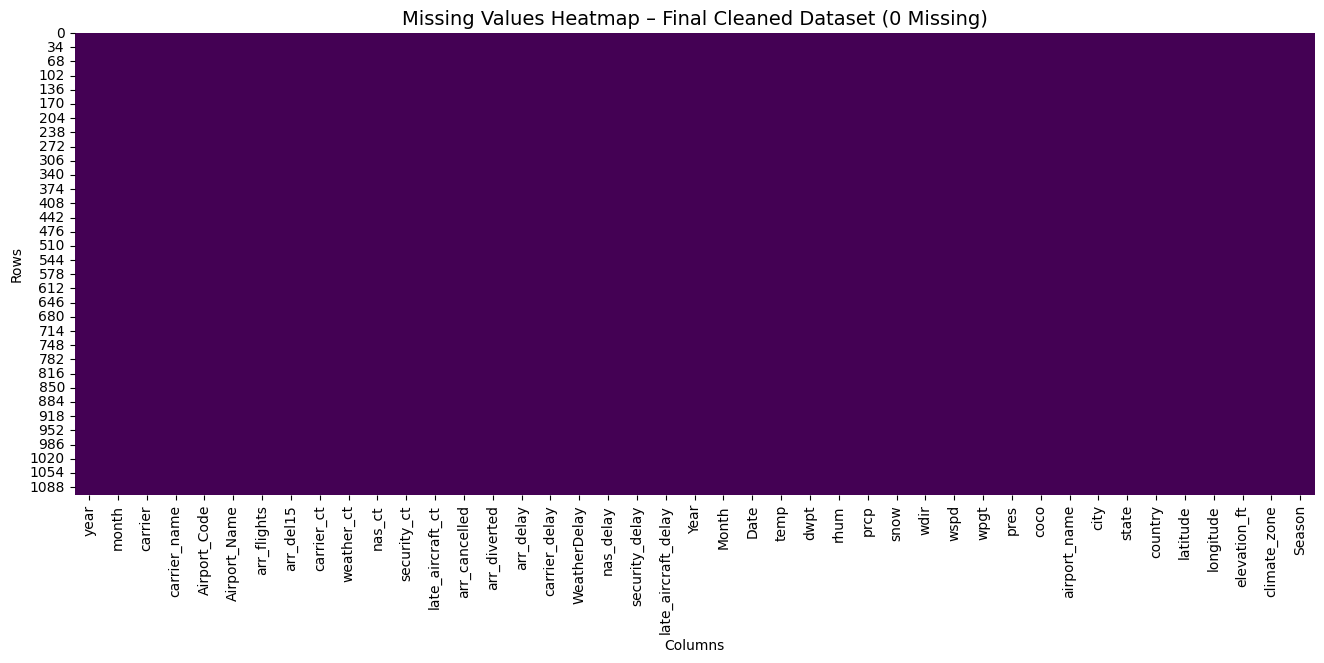

Total missing values: 0


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the newest cleaned file
df = pd.read_csv("/Users/vedant36/Desktop/Cleaned_FlightDelay_Master_Final.csv")

plt.figure(figsize=(16, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap – Final Cleaned Dataset (0 Missing)", fontsize=14)
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

print("Total missing values:", df.isnull().sum().sum())

# Stage 3: EDA

In [24]:
# ----------------------------------------------------------
# STEP 1: Import libraries
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
plt.style.use("seaborn-v0_8")

# Load the cleaned dataset
df = pd.read_csv(f"/Users/vedant36/Desktop/Cleaned_FlightDelay_Master_Final.csv")

print("Cleaned dataset loaded for EDA")
print(df.shape)
df.head()


Cleaned dataset loaded for EDA
(1107, 43)


,year,month,carrier,carrier_name,Airport_Code,Airport_Name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,WeatherDelay,nas_delay,security_delay,late_aircraft_delay,Year,Month,Date,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,airport_name,city,state,country,latitude,longitude,elevation_ft,climate_zone,Season
0,2024,12,MQ,Envoy Air,IAH,"Houston, TX: George Bush Intercontinental/Houston",138.0,14.0,2.44,0.25,6.47,0.0,4.84,5.0,1.0,1227.0,88.0,71.0,529.0,0.0,539.0,2024,12,2024-12-01,21.862055,15.420137,70.80274,0.159945,0.0,138.806849,12.536027,12.536027,1015.496849,3.874828,George Bush Intercontinental Airport,Houston,Texas,USA,29.9844,-95.3414,97,Humid Subtropical,Winter
1,2024,12,NK,Spirit Airlines,IAH,"Houston, TX: George Bush Intercontinental/Houston",800.0,178.0,41.30,4.47,79.89,1.0,51.34,3.0,1.0,11829.0,3597.0,162.0,4098.0,29.0,3943.0,2024,12,2024-12-01,21.862055,15.420137,70.80274,0.159945,0.0,138.806849,12.536027,12.536027,1015.496849,3.874828,George Bush Intercontinental Airport,Houston,Texas,USA,29.9844,-95.3414,97,Humid Subtropical,Winter
2,2024,12,OH,PSA Airlines Inc.,IAH,"Houston, TX: George Bush Intercontinental/Houston",24.0,7.0,0.61,0.72,4.90,0.0,0.77,0.0,1.0,325.0,45.0,48.0,163.0,0.0,69.0,2024,12,2024-12-01,21.862055,15.420137,70.80274,0.159945,0.0,138.806849,12.536027,12.536027,1015.496849,3.874828,George Bush Intercontinental Airport,Houston,Texas,USA,29.9844,-95.3414,97,Humid Subtropical,Winter
3,2024,12,OO,SkyWest Airlines Inc.,IAH,"Houston, TX: George Bush Intercontinental/Houston",937.0,186.0,95.45,16.52,31.29,0.0,42.74,17.0,4.0,19723.0,8028.0,3471.0,3172.0,0.0,5052.0,2024,12,2024-12-01,21.862055,15.420137,70.80274,0.159945,0.0,138.806849,12.536027,12.536027,1015.496849,3.874828,George Bush Intercontinental Airport,Houston,Texas,USA,29.9844,-95.3414,97,Humid Subtropical,Winter
4,2024,12,UA,United Air Lines Network,IAH,"Houston, TX: George Bush Intercontinental/Houston",6015.0,1152.0,359.25,25.76,483.26,0.0,283.73,68.0,15.0,90828.0,25210.0,4046.0,28838.0,0.0,32734.0,2024,12,2024-12-01,21.862055,15.420137,70.80274,0.159945,0.0,138.806849,12.536027,12.536027,1015.496849,3.874828,George Bush Intercontinental Airport,Houston,Texas,USA,29.9844,-95.3414,97,Humid Subtropical,Winter


In [25]:
# Analyze delay columns by showing summary stats and variance
delay_cols = [
    "arr_delay", "carrier_delay", "WeatherDelay",
    "nas_delay", "security_delay", "late_aircraft_delay"
]

print(df[delay_cols].describe())

print("\nVariance of delay columns:\n")
print(df[delay_cols].var())


           arr_delay  carrier_delay  WeatherDelay     nas_delay  security_delay  late_aircraft_delay
count    1107.000000    1107.000000   1107.000000   1107.000000     1107.000000          1107.000000
mean    11078.158085    3889.018067    650.443541   2180.255646       18.190605          4340.250226
std     19217.525904    6266.359690   1620.009477   4349.798441       58.915752          8563.539859
min         0.000000       0.000000      0.000000      0.000000        0.000000             0.000000
25%       561.500000     188.000000      0.000000    138.000000        0.000000           113.000000
50%      2372.000000     961.000000     81.000000    430.000000        0.000000           539.000000
75%     12667.500000    4863.000000    532.000000   2191.500000        0.000000          3694.500000
max    157016.000000   53506.000000  21987.000000  47668.000000     1102.000000         67507.000000

Variance of delay columns:

arr_delay              3.693133e+08
carrier_delay          3.9

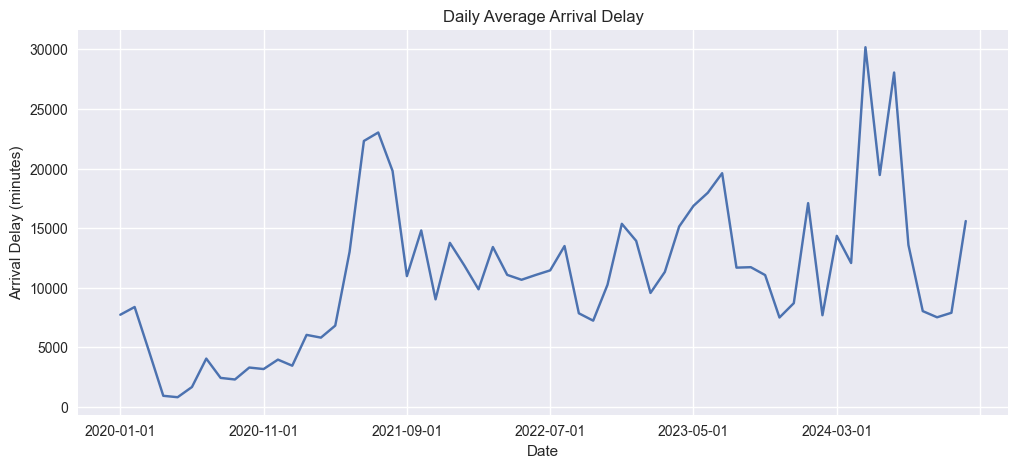

In [26]:
# Plot daily average arrival delay over time

daily_trend = df.groupby("Date")["arr_delay"].mean()

plt.figure(figsize=(12,5))
daily_trend.plot()
plt.title("Daily Average Arrival Delay")
plt.ylabel("Arrival Delay (minutes)")
plt.xlabel("Date")
plt.show()


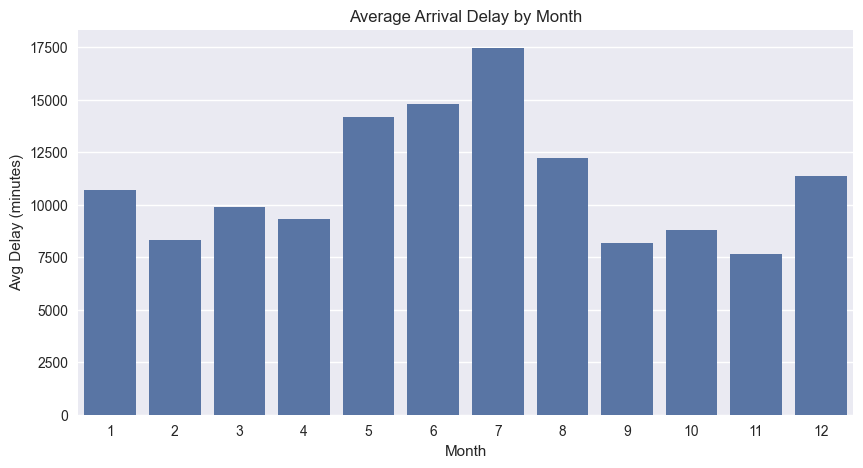

In [27]:
# Plot monthly average arrival delay as a bar chart
monthly = df.groupby("month")["arr_delay"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=monthly, x="month", y="arr_delay")
plt.title("Average Arrival Delay by Month")
plt.xlabel("Month")
plt.ylabel("Avg Delay (minutes)")
plt.show()


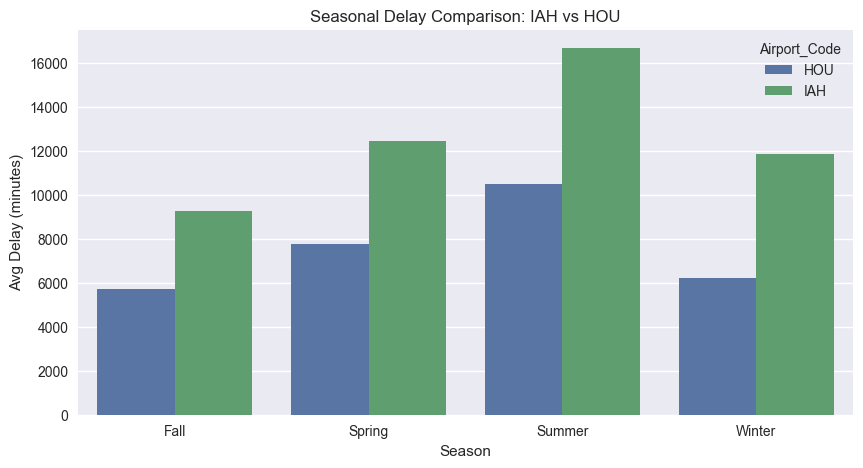

In [28]:
# Compare seasonal average delays between IAH and HOU

season_airport = (
    df.groupby(["Airport_Code","Season"])["arr_delay"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(
    data=season_airport,
    x="Season",
    y="arr_delay",
    hue="Airport_Code"
)
plt.title("Seasonal Delay Comparison: IAH vs HOU")
plt.ylabel("Avg Delay (minutes)")
plt.show()


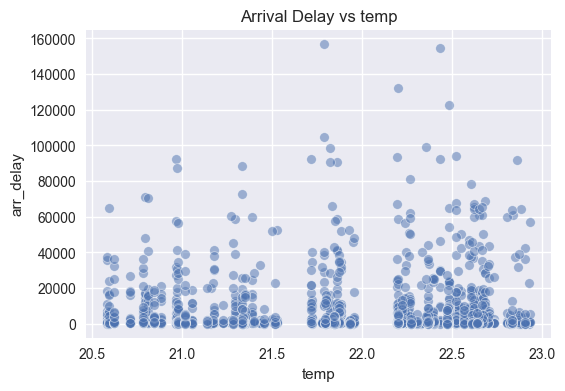

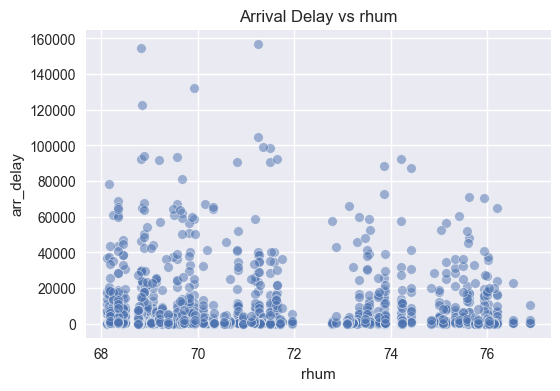

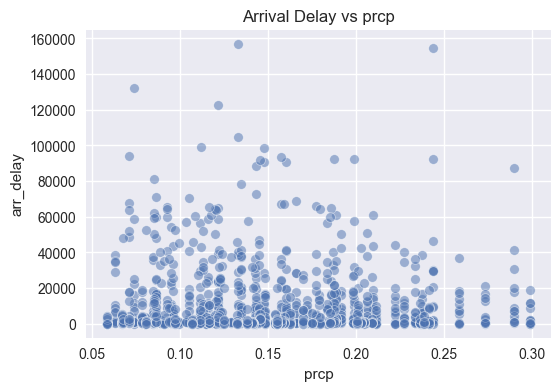

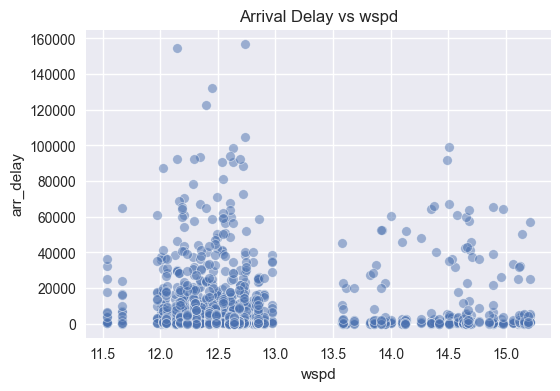

In [29]:
# Plot arrival delay against each weather variable

weather_vars = ["temp", "rhum", "prcp", "wspd"]

for col in weather_vars:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=col, y="arr_delay", alpha=0.5)
    plt.title(f"Arrival Delay vs {col}")
    plt.show()


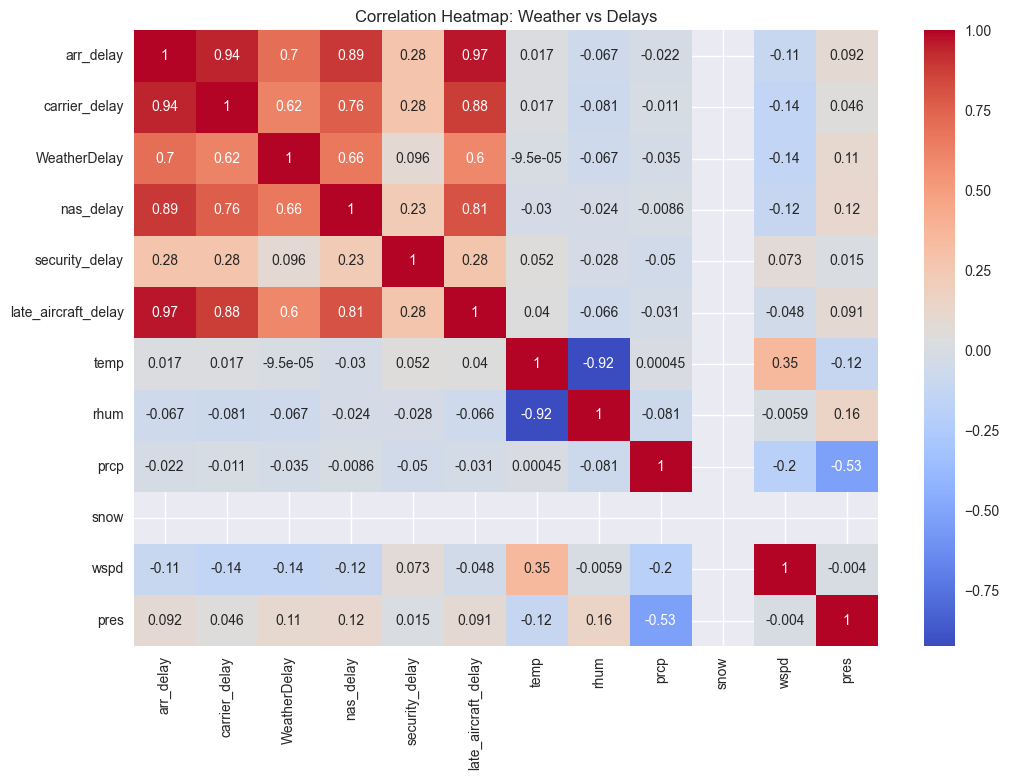

In [30]:
# Create a correlation heatmap for delays and weather features

heatmap_cols = delay_cols + ["temp","rhum","prcp","snow","wspd","pres"]

corr = df[heatmap_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap: Weather vs Delays")
plt.show()


In [31]:
# Print average delays and list weather factors most correlated with delays
avg_delays_by_airport = df.groupby("Airport_Code")["arr_delay"].mean()
avg_delays_by_season = df.groupby("Season")["arr_delay"].mean()
delay_weather_corr = corr["arr_delay"].sort_values(ascending=False)

print("\nAverage Delay by Airport:\n", avg_delays_by_airport)
print("\nAverage Delay by Season:\n", avg_delays_by_season)
print("\nWeather factors most correlated with delay:\n", delay_weather_corr)



Average Delay by Airport:
 Airport_Code
HOU     7526.835366
IAH    12573.451861
Name: arr_delay, dtype: float64

Average Delay by Season:
 Season
Fall       8200.705882
Spring    11120.505376
Summer    14841.324818
Winter    10155.265957
Name: arr_delay, dtype: float64

Weather factors most correlated with delay:
 arr_delay              1.000000
late_aircraft_delay    0.966177
carrier_delay          0.942106
nas_delay              0.892563
WeatherDelay           0.704439
security_delay         0.278224
pres                   0.091904
temp                   0.016695
prcp                  -0.022396
rhum                  -0.067063
wspd                  -0.106019
snow                        NaN
Name: arr_delay, dtype: float64


# Stage 4: Data Visualization

In [32]:

# This section loads the cleaned master dataset, fixes date fields,
# recalculates delay_rate as the percentage of flights delayed ≥15 minutes,
# selects only the required weather and airport columns,
# and builds a clean working dataframe for all further analysis.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")

#  LOAD & PREPARE DATA 

df = pd.read_csv("/Users/vedant36/Desktop/Cleaned_FlightDelay_Master_Final.csv")

# Ensure Date, Year, Month exist and are correct
df["Date"] = pd.to_datetime(df.get("Date", pd.NaT), errors="coerce")
df["Year"] = df.get("Year", df["Date"].dt.year)
df["Month"] = df.get("Month", df["Date"].dt.month)

# compute delay_rate as percentage of flights delayed ≥15 minutes
# arr_del15 = number of flights delayed 15+ min, arr_flights = total flights
if {"arr_del15", "arr_flights"}.issubset(df.columns):
    df["delay_rate"] = (df["arr_del15"] / df["arr_flights"]) * 100
    df.loc[~np.isfinite(df["delay_rate"]), "delay_rate"] = np.nan

# Make sure per-flight average arrival delay exists
if "avg_arr_delay" not in df.columns and {"arr_delay", "arr_flights"}.issubset(df.columns):
    df["avg_arr_delay"] = df["arr_delay"] / df["arr_flights"]

# Weather columns present in the cleaned dataset
weather_cols = [
    c
    for c in ["temp", "dwpt", "rhum", "prcp", "snow",
              "wdir", "wspd", "wpgt", "pres", "coco"]
    if c in df.columns
]

# Columns we need for analysis
keep = [
    "Date", "Year", "Month", "Airport_Code",
    "arr_delay", "delay_rate", "Season",
    "elevation_ft", "climate_zone"
] + weather_cols

work = df[keep].dropna(subset=["Airport_Code"]).copy()


In [34]:
# CORRELATION ANALYSIS 
# This checks how weather & geography relate to delays.

targets = [c for c in ["arr_delay", "delay_rate"] if c in work.columns]
feat_w = [c for c in ["temp", "dwpt", "rhum", "prcp", "snow",
                      "wdir", "wspd", "wpgt", "pres", "coco"]
          if c in work.columns]
feat_g = [c for c in ["elevation_ft"] if c in work.columns]

corr_tables = {}
for t in targets:
    sub = work[feat_w + feat_g + [t]].dropna()
    corr_tables[t] = (
        sub[feat_w + feat_g]
        .corrwith(sub[t])
        .to_frame("pearson_r")
        .sort_values("pearson_r", key=lambda s: s.abs(), ascending=False)
    )

print("Correlation of weather/geography with delay_rate:")
if "delay_rate" in corr_tables:
    print(corr_tables["delay_rate"].head(10))
else:
    print("delay_rate not available in corr_tables.")



Correlation of weather/geography with delay_rate:
              pearson_r
pres           0.138010
prcp          -0.074738
dwpt           0.045138
coco           0.026094
wdir           0.020855
rhum          -0.018655
temp           0.016419
wspd           0.012166
wpgt           0.012166
elevation_ft  -0.002187


In [35]:
#  SEASONAL DELAY ANALYSIS 
# delay_rate is a PERCENTAGE (%) of flights delayed ≥15 minutes.

seasonal = (
    work.dropna(subset=["Season", "delay_rate"])
    .groupby("Season", as_index=False)["delay_rate"]
    .mean()
    .sort_values("delay_rate", ascending=False)
)

print("\nAverage Delay Rate by Season (% of flights delayed 15+ minutes):")
print(seasonal)


Average Delay Rate by Season (% of flights delayed 15+ minutes):
   Season  delay_rate
2  Summer   22.393049
1  Spring   19.318415
3  Winter   18.995773
0    Fall   16.256897


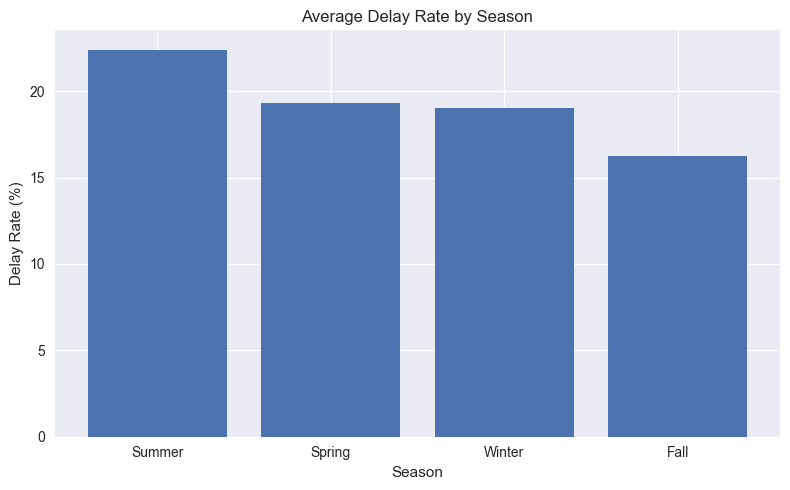

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.bar(seasonal["Season"], seasonal["delay_rate"])

plt.title("Average Delay Rate by Season")
plt.xlabel("Season")
plt.ylabel("Delay Rate (%)")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [37]:
# SUDDEN WEATHER CHANGE ANALYSIS 
# Compute day-over-day absolute changes in key weather variables per airport.

work = work.sort_values(["Airport_Code", "Date"]).copy()

for c in [x for x in ["temp", "rhum", "wspd", "pres", "prcp"] if x in work.columns]:
    work[f"d_{c}"] = work.groupby("Airport_Code")[c].diff().abs()

delta_cols = [c for c in ["d_temp", "d_rhum", "d_wspd", "d_pres", "d_prcp"] if c in work.columns]

dcorr = (
    work[delta_cols + ["delay_rate"]]
    .dropna()
    .corrwith(work["delay_rate"])
    .to_frame("pearson_r")
    .sort_values("pearson_r", key=lambda s: s.abs(), ascending=False)
)

print("\nCorrelation between sudden weather changes and delay_rate:")
print(dcorr)



Correlation between sudden weather changes and delay_rate:
            pearson_r
delay_rate   1.000000
d_rhum      -0.031780
d_temp      -0.019961
d_wspd      -0.015336
d_prcp       0.005685
d_pres      -0.001461


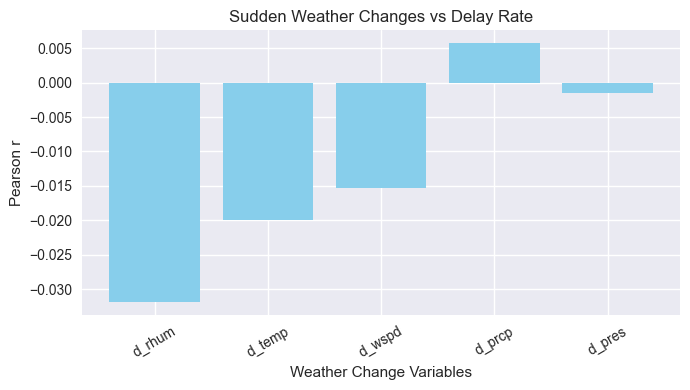

In [44]:
import matplotlib.pyplot as plt

# Prepare data for chart 

plt.figure(figsize=(7,4))
plt.bar(corr_values.index, corr_values["pearson_r"], color='skyblue')

plt.title("Sudden Weather Changes vs Delay Rate")
plt.ylabel("Pearson r")
plt.xlabel("Weather Change Variables")

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# Testing Purpose

In [39]:
# PREDICTIVE MODEL (STANDARDIZED OLS) 
# Simple linear regression to see relative influence of each feature on delay_rate.

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

target = "delay_rate"

num_feats = [
    c for c in [
        "temp", "dwpt", "rhum", "prcp",
        "wdir", "wspd", "wpgt", "pres", "elevation_ft",
        "d_temp", "d_rhum", "d_wspd", "d_pres", "d_prcp"
    ]
    if c in work.columns
]

cat_feats = [c for c in ["climate_zone"] if c in work.columns]

data = work[num_feats + cat_feats + [target, "Year"]].dropna().copy()

# Time-based split: train on ≤2023, test on 2024 if it exists.
if data["Year"].max() >= 2024:
    mask = data["Year"] <= 2023
else:
    mask = None

X_train = data.loc[mask, num_feats + cat_feats] if mask is not None else data[num_feats + cat_feats]
y_train = data.loc[mask, target] if mask is not None else data[target]

if mask is not None:
    X_test = data.loc[~mask, num_feats + cat_feats]
    y_test = data.loc[~mask, target]
else:
    # Fallback: random 80/20 split when 2024 is not present
    X_test = X_train.sample(frac=0.2, random_state=42)
    y_test = y_train.loc[X_test.index]

pre = ColumnTransformer([
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
])

pipe = Pipeline([
    ("prep", pre),
    ("lin", LinearRegression())
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("\nModel performance on test set:")
print({
    "r2_test": r2_score(y_test, pred),
    "mae_test": float(np.mean(np.abs(y_test - pred))),
    "n_train": int(len(y_train)),
    "n_test": int(len(y_test)),
})


Model performance on test set:
{'r2_test': -0.053419984978487545, 'mae_test': 8.476862710925955, 'n_train': 882, 'n_test': 223}


In [40]:
#FEATURE IMPORTANCE (COEFFICIENTS) 

ohe = pipe.named_steps["prep"].named_transformers_.get("cat")
cat_names = ohe.get_feature_names_out(cat_feats).tolist() if (ohe is not None and cat_feats) else []
feature_names = num_feats + cat_names

coefs = pd.DataFrame({
    "feature": feature_names,
    "coef": pipe.named_steps["lin"].coef_
})
coefs["abs_coef"] = coefs["coef"].abs()

print("\nTop 10 influential features (by |standardized coefficient|):")
top_coefs = coefs.sort_values("abs_coef", ascending=False).head(10)
print(top_coefs)


Top 10 influential features (by |standardized coefficient|):
         feature       coef   abs_coef
2           rhum  26.060219  26.060219
0           temp  22.512723  22.512723
1           dwpt -12.827860  12.827860
7           pres   7.267708   7.267708
10        d_rhum  -5.182709   5.182709
9         d_temp   3.952742   3.952742
8   elevation_ft   3.188101   3.188101
5           wspd   2.765354   2.765354
6           wpgt   2.765354   2.765354
4           wdir  -2.281629   2.281629


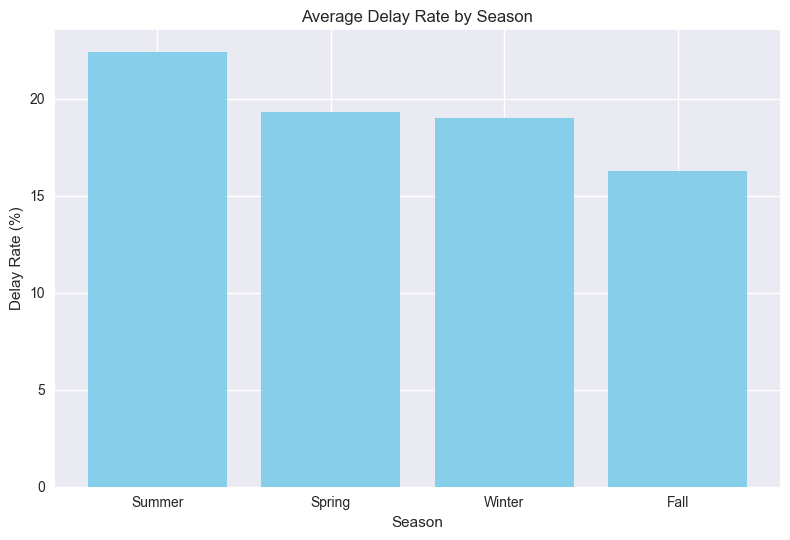

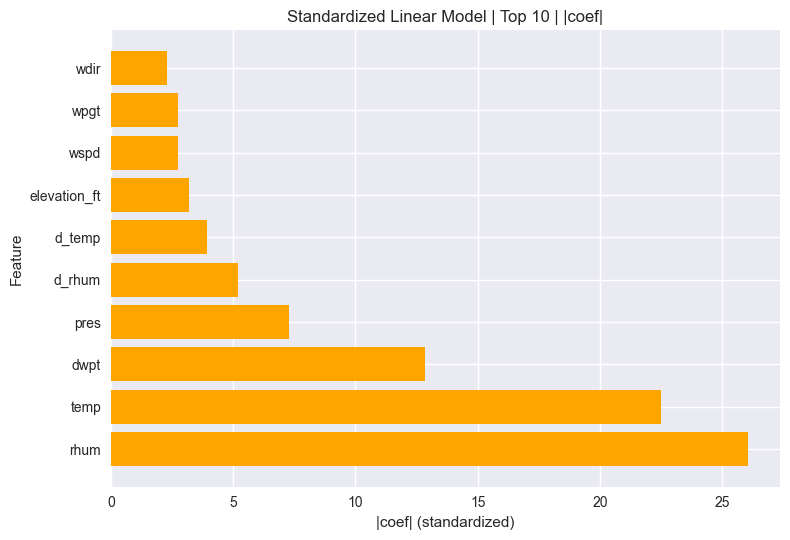

In [41]:
# MINIMAL CORE VISUALS 

# 1) Seasonal bar chart (delay rate by season)
plt.figure()
plt.bar(seasonal["Season"], seasonal["delay_rate"], color="skyblue")
plt.title("Average Delay Rate by Season")
plt.xlabel("Season")
plt.ylabel("Delay Rate (%)")
plt.tight_layout()
plt.show()

# 2. Top-10 standardized coefficients 
top_coefs = coefs.sort_values('abs_coef', ascending=False).head(10)

plt.figure()
plt.barh(top_coefs['feature'], top_coefs['abs_coef'], color='orange')
plt.title("Standardized Linear Model | Top 10 | |coef|")
plt.xlabel("|coef| (standardized)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


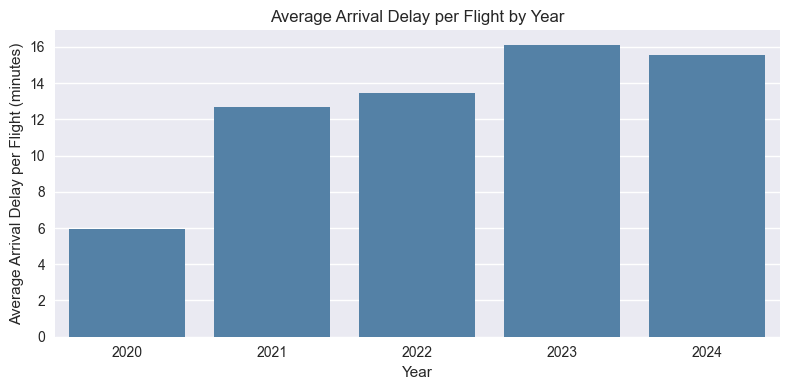

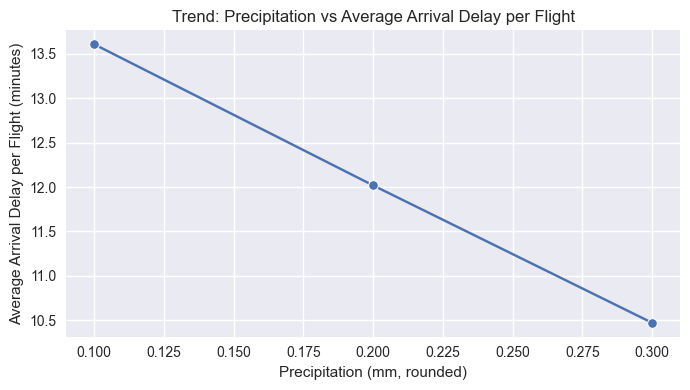

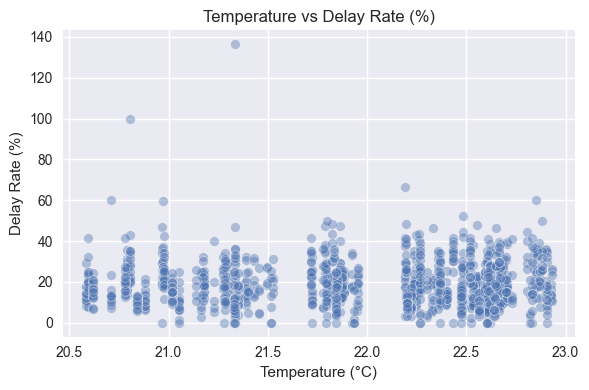

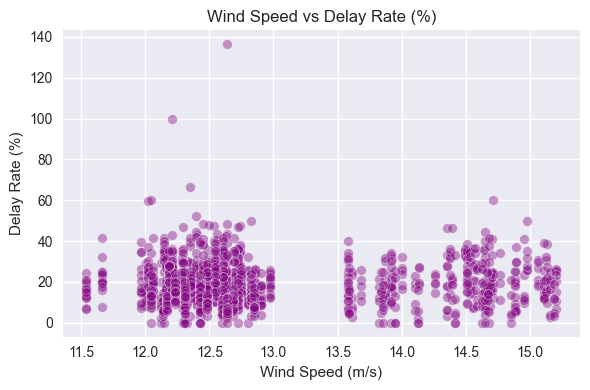

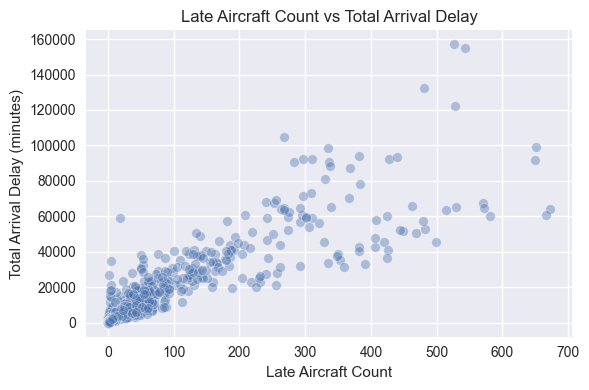

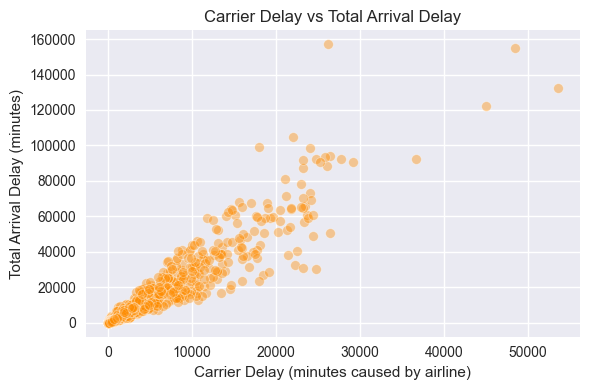

In [42]:

# WEATHER–DELAY VISUALS 

# YEARLY AVERAGE ARRIVAL DELAY PER FLIGHT
yearly_delay = (
    df.groupby("Year")["avg_arr_delay"]
    .mean()
    .reset_index()
    .sort_values("Year")
)

plt.figure(figsize=(8, 4))
sns.barplot(data=yearly_delay, x="Year", y="avg_arr_delay", color="steelblue")
plt.title("Average Arrival Delay per Flight by Year")
plt.xlabel("Year")
plt.ylabel("Average Arrival Delay per Flight (minutes)")
plt.tight_layout()
plt.show()


# PRECIPITATION VS AVERAGE ARRIVAL DELAY (LINE TREND)
rain_delay_line = (
    df[["prcp", "avg_arr_delay"]]
    .dropna()
    .sort_values("prcp")
)
rain_delay_line["prcp_bin"] = rain_delay_line["prcp"].round(1)

trend = (
    rain_delay_line.groupby("prcp_bin")["avg_arr_delay"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(7, 4))
sns.lineplot(data=trend, x="prcp_bin", y="avg_arr_delay", marker="o")
plt.title("Trend: Precipitation vs Average Arrival Delay per Flight")
plt.xlabel("Precipitation (mm, rounded)")
plt.ylabel("Average Arrival Delay per Flight (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()


# TEMPERATURE VS DELAY RATE (SCATTER)
sample_temp = df[["temp", "delay_rate"]].dropna()
if len(sample_temp) > 4000:
    sample_temp = sample_temp.sample(4000, random_state=42)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=sample_temp, x="temp", y="delay_rate", alpha=0.4)
plt.title("Temperature vs Delay Rate (%)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Delay Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


# WIND SPEED VS DELAY RATE (SCATTER)
sample_wind = df[["wspd", "delay_rate"]].dropna()
if len(sample_wind) > 4000:
    sample_wind = sample_wind.sample(4000, random_state=42)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=sample_wind, x="wspd", y="delay_rate", alpha=0.4, color="purple")
plt.title("Wind Speed vs Delay Rate (%)")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Delay Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


# LATE AIRCRAFT COUNT VS ARRIVAL DELAY
if {"late_aircraft_ct", "arr_delay"}.issubset(df.columns):
    n = min(5000, len(df))
    sample_late = df[["late_aircraft_ct", "arr_delay"]].sample(n, random_state=42)
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=sample_late, x="late_aircraft_ct", y="arr_delay", alpha=0.4)
    plt.title("Late Aircraft Count vs Total Arrival Delay")
    plt.xlabel("Late Aircraft Count")
    plt.ylabel("Total Arrival Delay (minutes)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# CARRIER DELAY VS ARRIVAL DELAY
if {"carrier_delay", "arr_delay"}.issubset(df.columns):
    n = min(5000, len(df))
    sample_carrier = df[["carrier_delay", "arr_delay"]].sample(n, random_state=42)
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=sample_carrier, x="carrier_delay", y="arr_delay", alpha=0.4, color="darkorange")
    plt.title("Carrier Delay vs Total Arrival Delay")
    plt.xlabel("Carrier Delay (minutes caused by airline)")
    plt.ylabel("Total Arrival Delay (minutes)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()